# Baseline Model

In this notebook, we will build a baseline (Decision Tree) model for network intrusion malware classification. This will serve as the basis for comparision and evaluating the effectiveness of our deep learning models and methodology in subsequent notebooks.

We will use `X_train.pkl`, `X_test.pkl`, `y_train.pkl` and `y_test.pkl` generated from `Basic_preprocessing.ipynb` to train our model. The preprocessing steps can be found in detail over at `Basic_preprocessing.ipynb` notebook. The steps on how we dealt with each column are carefully crafted based on our EDA process and are detailed in the report. 

In [13]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

type_mapping = {
    'Normal': 12,
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11
}
reverse_type_mapping = {v: k for k, v in type_mapping.items()}


## Load Data

In [46]:
X_train = pd.read_pickle(os.path.join('data', 'X_train.pkl'))
X_test = pd.read_pickle(os.path.join('data', 'X_test.pkl'))
y_train = pd.read_pickle(os.path.join('data', 'y_train.pkl'))
y_test = pd.read_pickle(os.path.join('data', 'y_test.pkl'))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1482238, 99) (635245, 99) (1482238, 1) (635245, 1)


## Train Model

We will ignore the `frame.time` column for our baseline as there are extra considerations (which we have outlined in our report) to be made and it will be discussed in other notebooks.

In [48]:
X_train.drop(columns=['frame.time'], inplace=True)
X_test.drop(columns=['frame.time'], inplace=True)

In [5]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# save the model
import joblib
MODEL_FILE = os.path.join('models', 'decision_tree.pkl')
joblib.dump(model, MODEL_FILE)

# load the model
model = joblib.load(MODEL_FILE)

## Evaluate the Model

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.98      0.95      0.96      7459
            DDoS_HTTP       0.86      0.86      0.86     44658
            DDoS_ICMP       1.00      1.00      1.00     43715
             DDoS_TCP       1.00      0.68      0.81     42422
               Normal       1.00      1.00      1.00    367217
    OS_Fingerprinting       1.00      0.86      0.92       300
             Password       0.83      0.83      0.83     44242
        Port_Scanning       0.85      1.00      0.92      6769
           Ransomware       0.93      0.85      0.89      3278
        SQL_injection       0.77      0.77      0.77     15361
            Uploading       0.81      0.84      0.83     11290
Vulnerability_scanner       0.96      0.96      0.96     43759
                  XSS       0.18      0.69      0.29      4775

             accuracy                           0.94    635245
            macro avg       0.

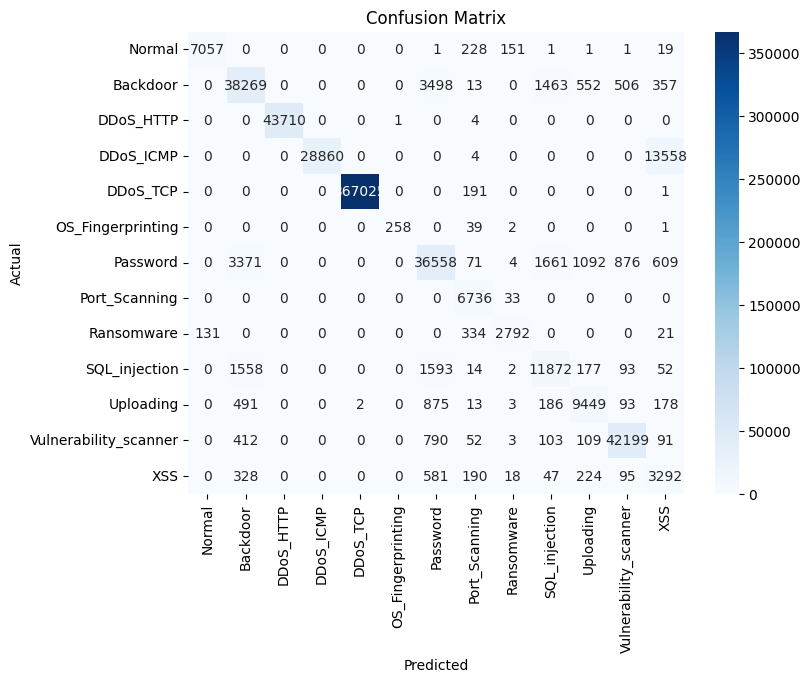

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred = model.predict(X_test)

y_pred_raw = [reverse_type_mapping[y] for y in y_pred]
y_test_raw = [reverse_type_mapping[y] for y in y_test["Attack_type"].values]

# Print classification report with proper class names
print("Classification Report:")
print(classification_report(y_test_raw, y_pred_raw))

# Print confusion matrix
conf_mat = confusion_matrix(y_test_raw, y_pred_raw)
# print("Confusion Matrix:")
# print(conf_mat)

# Plot confusion matrix with proper class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=type_mapping.keys(), yticklabels=type_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Feature Importance

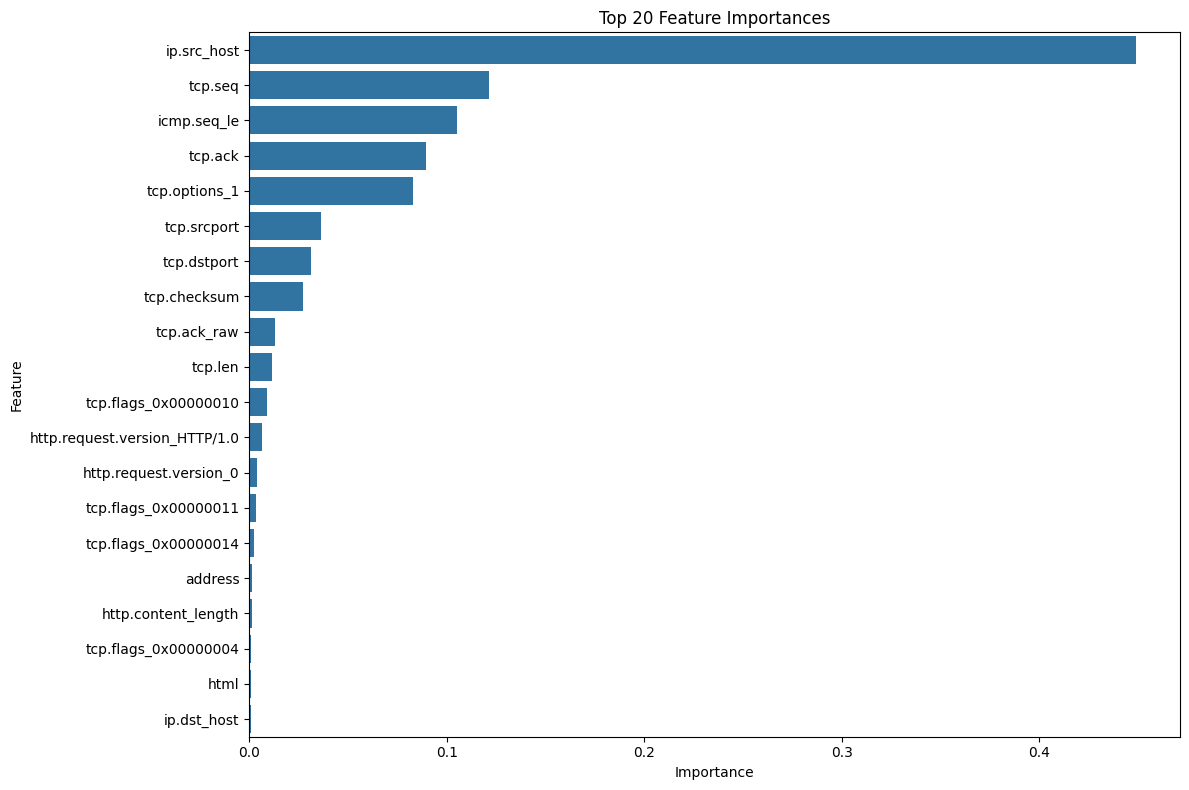

In [8]:
# Get feature importances from the model
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

### AUC-ROC

In [50]:
## plot micro and macro auc-roc curve
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)
    
    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']
    
    for i, color in zip(range(n_classes), colors):
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
                 linestyle='--')
        

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

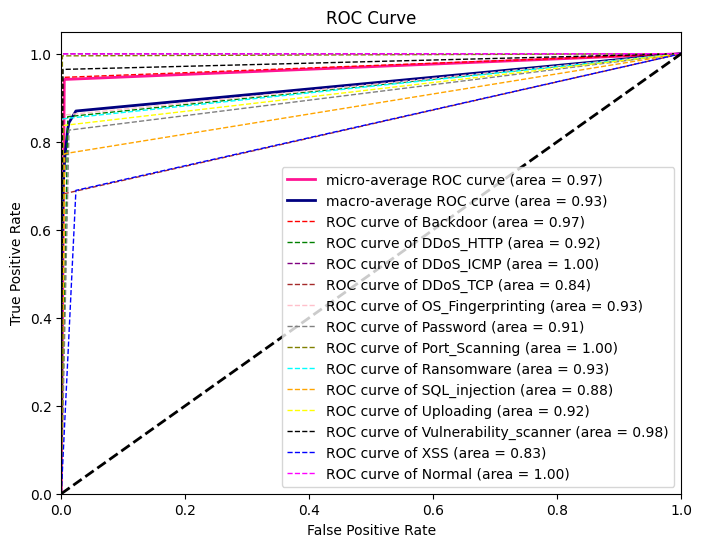

In [51]:
plot_roc_curve(y_test, y_pred, n_classes=len(np.unique(y_test)))